<a href="https://colab.research.google.com/github/rajibmondal/BioSigKit/blob/master/ExplainableECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Explainable ECG</center></h1>


### **Important**:To be able to see all graphs and visualization in this notebook i suggest you to swich the theme to dark. Click on the "wheel" in the upper right corner and select dark theme

In [ ]:
!pip install wfdb wget

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 163kB 8.9MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=918ade0f5c3db198c07842be1152edfbbe4d7bcc2bd17f85e7fd53524a2aed60
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=ab3c42cb9e3f68da2642752883717ed4255306788c8d85f1c9554185e7a453e0
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wfdb wget


In [ ]:
#@title Loading some packages and defining a function to load data
import os
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
import wget
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings



def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data


def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
#@title Get zip-file
url = "https://cloudypipeline.com:9555/api/download/physionet2020training/PhysioNetChallenge2020_Training_CPSC.tar.gz/"
filename = wget.download(url)
print("Done")


Done


In [ ]:
#@title Unzip file
def opentarfile(filename):
    if filename.endswith("tar.gz"):
        tar = tarfile.open(filename, "r:gz")
        tar.extractall()
        tar.close()
    elif filename.endswith("tar"):
        tar = tarfile.open(filename, "r:")
        tar.extractall()
        tar.close()
    print("Done")

opentarfile("PhysioNetChallenge2020_Training_CPSC.tar.gz")

#[ref] https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python

Done


# Feature Description
## Primary Features
This dataset contains 6877 Electrocariographic recordings from different patients. The data is given in the form of native Python waveform-database-format (WFDB)[ref : https://wfdb.readthedocs.io/en/latest/ ]. There ar two file types:


1.   Header files (.hea)
2.   Signal files (.mat)

We have 6877 Signal file with a corresponding header file. Each file are named with a patient number starting with ***A0001*** and goes all the way up to ***A6877***


In [ ]:
#@title Here is an example of a Header File:
ex_data, ex_header_data = load_challenge_data("./Training_WFDB/A0001.mat")
ex_header_data

['A0001 12 500 7500 16-Mar-2020 19:07:01\n',
 'A0001.mat 16+24 1000/mV 16 0 28 -1716 0 I\n',
 'A0001.mat 16+24 1000/mV 16 0 7 2029 0 II\n',
 'A0001.mat 16+24 1000/mV 16 0 -21 3745 0 III\n',
 'A0001.mat 16+24 1000/mV 16 0 -17 3680 0 aVR\n',
 'A0001.mat 16+24 1000/mV 16 0 24 -2664 0 aVL\n',
 'A0001.mat 16+24 1000/mV 16 0 -7 -1499 0 aVF\n',
 'A0001.mat 16+24 1000/mV 16 0 -290 390 0 V1\n',
 'A0001.mat 16+24 1000/mV 16 0 -204 157 0 V2\n',
 'A0001.mat 16+24 1000/mV 16 0 -96 -2555 0 V3\n',
 'A0001.mat 16+24 1000/mV 16 0 -112 49 0 V4\n',
 'A0001.mat 16+24 1000/mV 16 0 -596 -321 0 V5\n',
 'A0001.mat 16+24 1000/mV 16 0 -16 -3112 0 V6\n',
 '#Age: 74\n',
 '#Sex: Male\n',
 '#Dx: RBBB\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknown\n']

The first line:
'A0001 12 500 7500 16-Mar-2020 19:07:01\n'
describes 

*   The patient number - A0001
*   total number of leads - 12 leads
*   Sample frequenzy - 500 Hz
*   Signal length - 7500 samples
*   Date (downloaded?) - 16-Mar-2020 19:07:01

From the next 12 lines,
we see that: 
 
*   each signal was written at 16 bits with an offset of 24 bits
*   the amplitude resolution is 1000 with units in mV
*   the resolution of the analog-to-digital converter (ADC) used to digitize the signal is 16 bits
*   and the baseline value corresponding to 0 physical units is 0
*   The first value of the signal, the checksum,
*   and the lead name are included for each signal [ref: https://physionetchallenges.github.io/2020/#data ]

The last 6 lines show patient specific info:
*   #Age - gives us the age of the patient
*   #Sex - Gives us the gender of the patient
*   **#Dx - Gives us the diagnosis. This is our dependent variable which we are going to predict**
*   #Rx - medical prescription. Not given in this dataset
*   #Hx - history. Not given in this dataset
*   #Sx - symptom or surgery. Not given in this dataset

# Signal file
## 12 -lead ECG
The signal files (.mat -files) contains 12 electrocardiograpic (ECG) signals. 12 leads ECG is the medical standard at hospitals. To do a 12-lead ECG-recording, 10 electrodes hould be placed like in the figures under


<img src="https://i.pinimg.com/236x/c4/db/2f/c4db2f5c541f104cd160c7141bc4ec87--nurse-stuff-medical-assistant.jpg" width="400" height="400" />
<img src="https://i.pinimg.com/originals/cb/5d/b7/cb5db7a23d07a44de46658d3fc47e74a.gif" width="400" height="400" />

*Figure x - The left image shows placement of electrodes when recording a 12 lead ECG. The right image shows how the measurements are taken between the different electrodes so that one can see the electrical activity of the heart from all angles*

## Signal values
The signals are represented as float values. The length of the signals varies between 6 and 60 seconds.

In [ ]:
#@title Show example of Signal File as dataframe
ECGdf = pd.DataFrame(ex_data.T, columns=['Lead I', 'Lead II', 'Lead III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3','V4','V5','V6'])
ECGdf.head(10)

,Lead I,Lead II,Lead III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,28.0,7.0,-21.0,-17.0,24.0,-7.0,-290.0,-204.0,-96.0,-112.0,-596.0,-16.0
1,39.0,11.0,-28.0,-24.0,33.0,-9.0,-304.0,-212.0,-100.0,-110.0,-590.0,-7.0
2,45.0,15.0,-30.0,-29.0,38.0,-7.0,-317.0,-219.0,-105.0,-108.0,-582.0,2.0
3,49.0,17.0,-32.0,-32.0,41.0,-7.0,-329.0,-226.0,-109.0,-105.0,-573.0,13.0
4,54.0,20.0,-34.0,-36.0,44.0,-7.0,-342.0,-233.0,-111.0,-100.0,-561.0,24.0
5,56.0,24.0,-32.0,-39.0,44.0,-4.0,-353.0,-239.0,-113.0,-96.0,-551.0,35.0
6,58.0,29.0,-29.0,-42.0,44.0,0.0,-364.0,-246.0,-114.0,-90.0,-538.0,47.0
7,60.0,35.0,-25.0,-47.0,42.0,4.0,-373.0,-251.0,-114.0,-82.0,-526.0,61.0
8,60.0,41.0,-19.0,-50.0,39.0,10.0,-382.0,-258.0,-114.0,-74.0,-513.0,75.0
9,61.0,48.0,-13.0,-54.0,36.0,16.0,-390.0,-264.0,-113.0,-65.0,-500.0,88.0


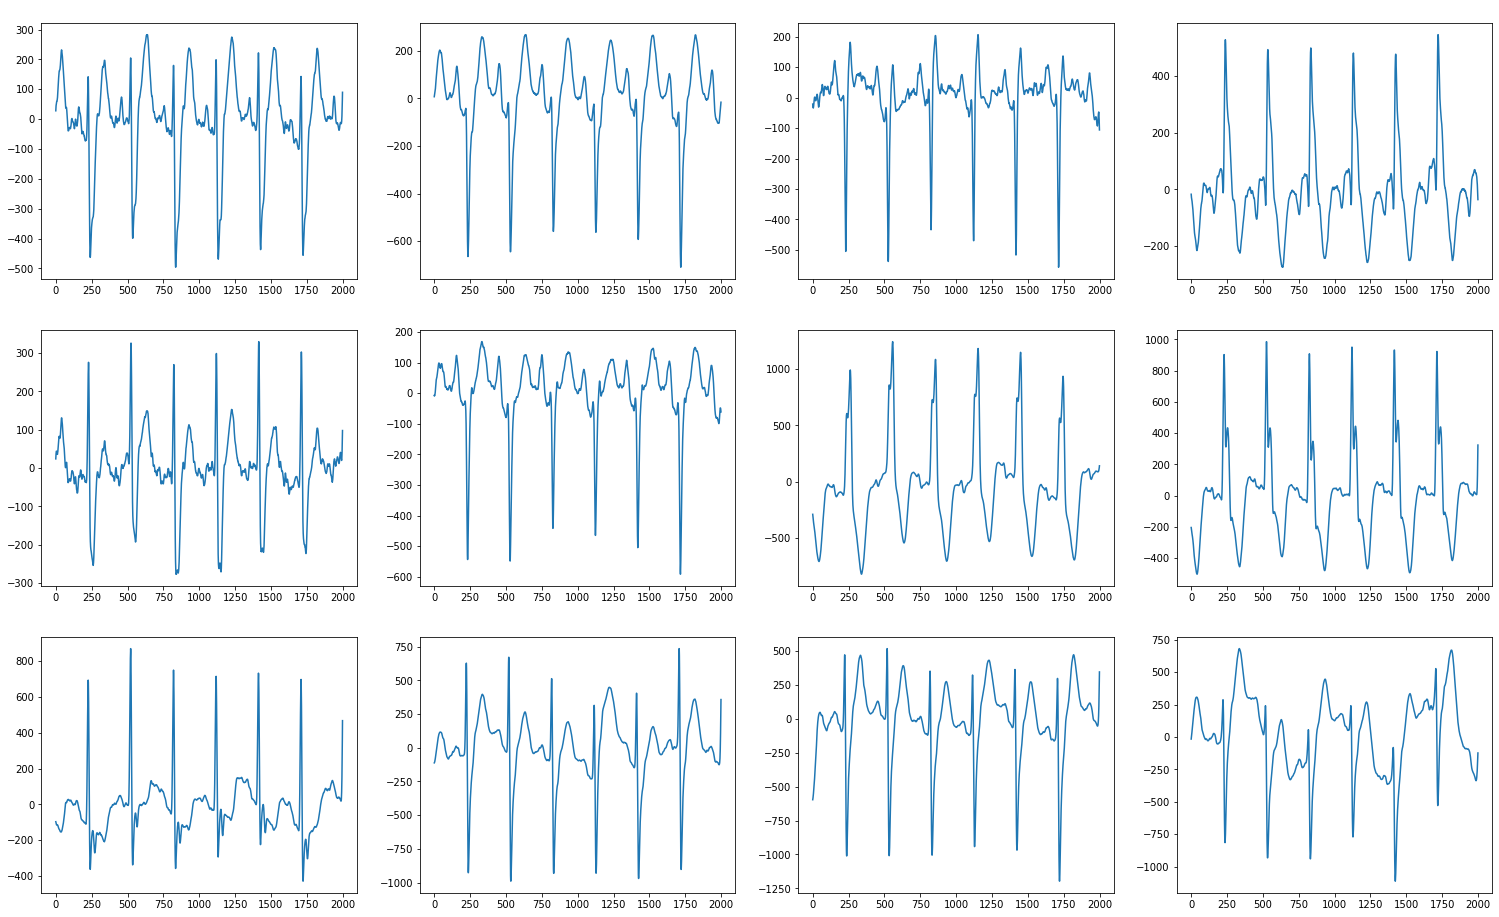

In [ ]:
#@title Represent a 12 lead ECG as graphs (4 seconds)

ECGdf_short = ECGdf[0:2000]
plt.figure(figsize=(26, 16))
for i, col in enumerate(ECGdf_short.columns[0:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(ECGdf_short[col])
    plt.title(col, color = "white")

# Predictions:
The goal is to identify clinical diagnoses from the 12-lead ECG recordings. There are 9 different diagnosis. Every patient has at least 1 diagnosis but there could also be 2 or more. This means that our classification problem is multilabel classification.

## Diagnosis
Below you can see the meaning of the diagnosis abbreviations in the header file:

    AF = Atrial Fibrillation
    I-AVB = 1 degree Atrioventricular Block
    LBBB = Left Bundle Branch Block
    Normal = Normal ECG
    PAC = Premature Atrial Contractions
    PVC = Premature Ventricular Contractions
    RBBB = Right Bundle Branch Block
    STD = ST-segment Depression
    STE = ST-segment Elevation

## Diagnosis distribution
In table 1 shows us the distribution of recordings from the different hospital and more important, the distribution between the different diagnosis.

![alt text](https://raw.githubusercontent.com/Bsingstad/Bsingstad.github.io/master/images/physionet_dataset.png)
*Figure 1 - [2]*


All of them are classified with a probabillity between 0 and 1

In [ ]:
#@title Import all Signals and Diagnosis to Notebook we truncate our signal to 1000 or 2 seconds. We will lose a lot of info but we need to shorten our signals to be able to run the explaination within a reasonable time
g=[]
o=[]
for filen in sorted(os.listdir("./Training_WFDB/")):
    if filen.endswith(".mat"):
        data, header_data = load_challenge_data("./Training_WFDB/"+filen)
        data = pad_sequences(data, maxlen=1000, truncating='post',padding="post")
        g.append(data)
        o.append(header_data[15][5:-1])

In [ ]:
#@title Y to dataframe and X to array 
X=np.asarray(g)
X = X.reshape(6877,1000,12)
y = pd.DataFrame(o)
print("Done")

Done


In [ ]:
#@title Plot distribution of Diagnosis:
labels=['AF', 'I-AVB', 'LBBB', 'Normal', 'PAC', 'PVC', 'RBBB', 'STD', 'STE']
plt.figure(figsize=(16,10))
plt.bar(x= labels, height=y.sum(axis=0))
plt.title("Distribution of Diagnosis", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.xlabel("Diagnosis", color = "white")
plt.ylabel("Count", color = "white")
plt.show()

ValueError: ignored

<Figure size 1152x720 with 1 Axes>

# A closer look at the pathological ECGs compared to the Normal


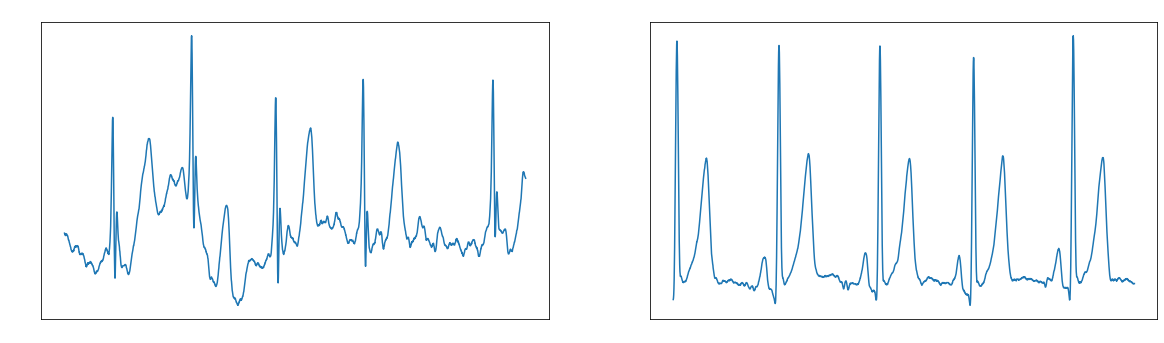

In [ ]:
#@title AF vs Normal
AF_data = load_challenge_data("./Training_WFDB/A0009.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
AF_data = AF_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(AF_data)
plt.title("AF Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

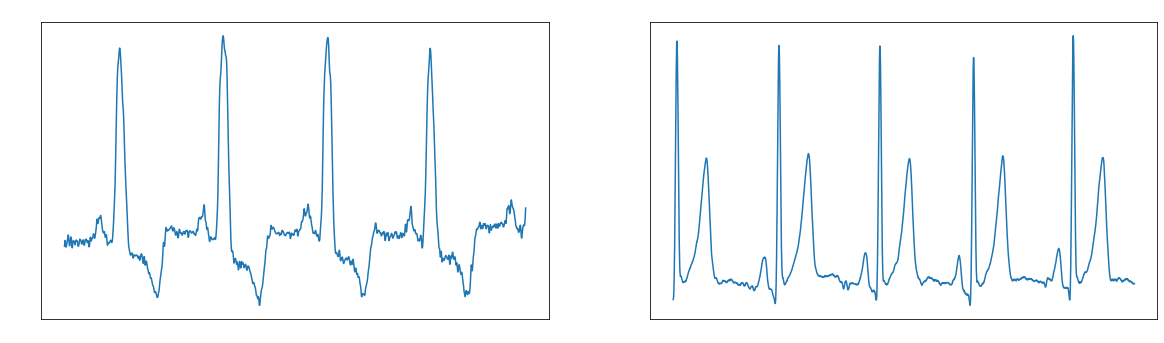

In [ ]:
#@title LBBB vs Normal
LBBB_data = load_challenge_data("./Training_WFDB/A0011.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
LBBB_data = LBBB_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(LBBB_data)
plt.title("LBBB Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

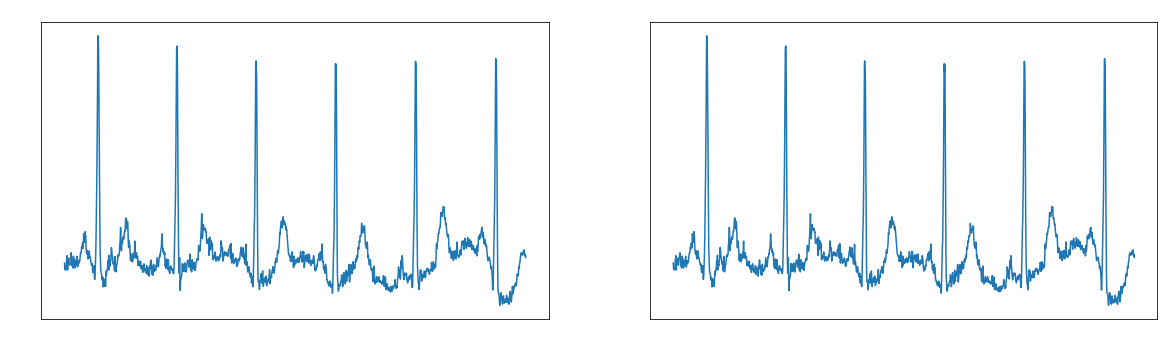

In [ ]:
#@title PAC vs Normal
PAC_data = load_challenge_data("./Training_WFDB/A0047.mat")
norm_data = load_challenge_data("./Training_WFDB/A0047.mat")
PAC_data = PAC_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(PAC_data)
plt.title("PAC Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

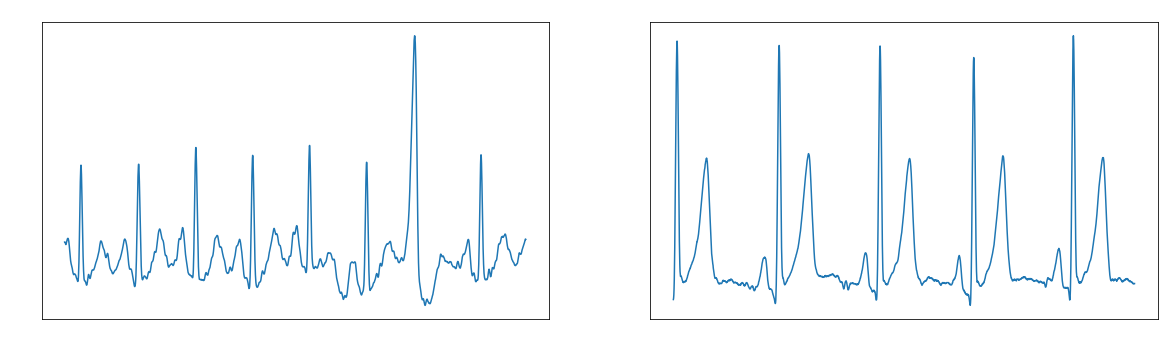

In [ ]:
#@title PVC vs Normal
PVC_data = load_challenge_data("./Training_WFDB/A0005.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
PVC_data = PVC_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(PVC_data)
plt.title("PVC Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

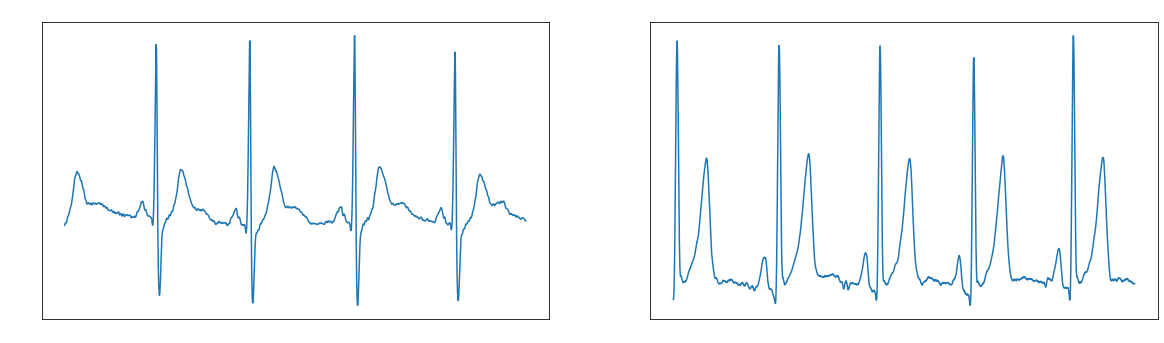

In [ ]:
#@title RBBB vs Normal
RBBB_data = load_challenge_data("./Training_WFDB/A0006.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
RBBB_data = RBBB_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(RBBB_data)
plt.title("RBBB Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()



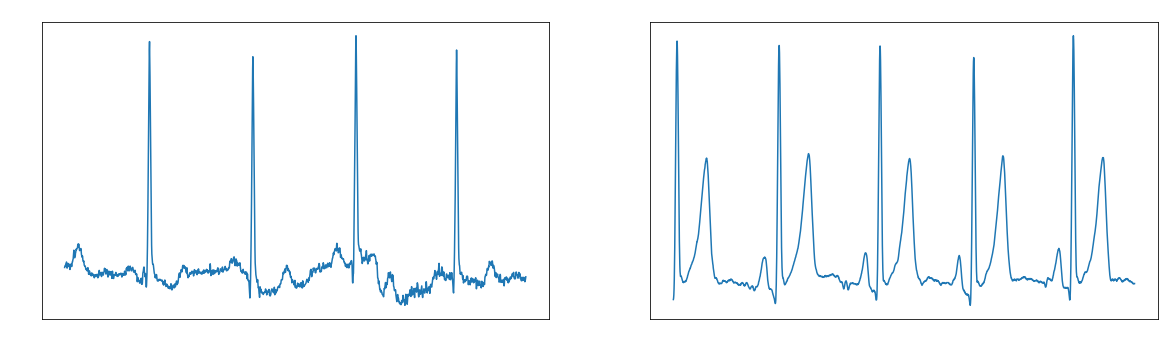

In [ ]:
#@title STD vs Normal
STD_data = load_challenge_data("./Training_WFDB/A0008.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
STD_data = STD_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(STD_data)
plt.title("STD Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

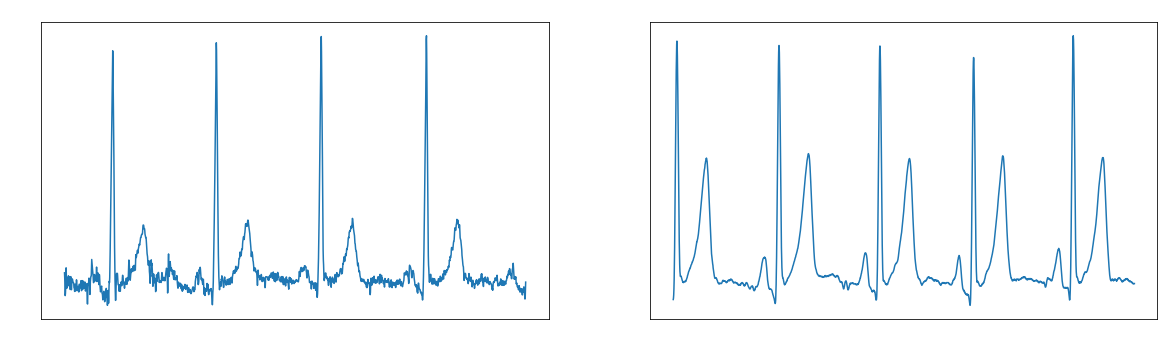

In [ ]:
#@title STE vs Normal
STE_data = load_challenge_data("./Training_WFDB/A0021.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
STE_data = STE_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(STE_data)
plt.title("STE Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

Sometimes we have even 2 pathological diagnosis in the same record:

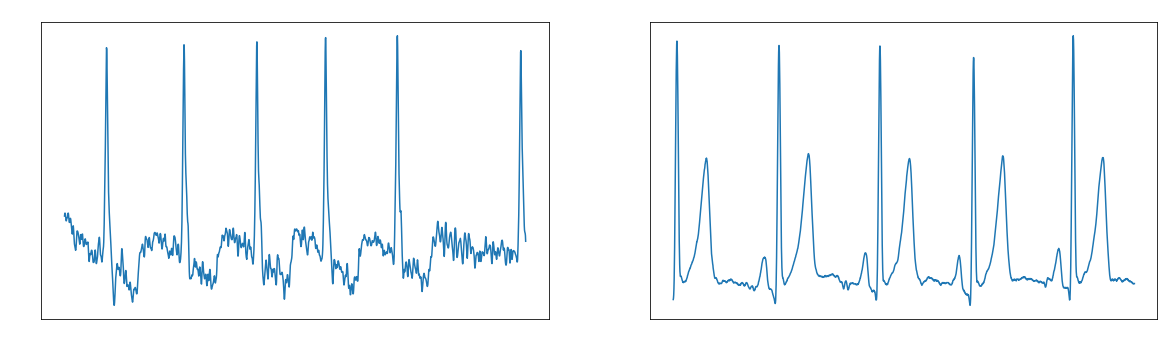

In [ ]:
#@title AF and RBBB vs Normal
AF_RBBB_data = load_challenge_data("./Training_WFDB/A0043.mat")
norm_data = load_challenge_data("./Training_WFDB/A0016.mat")
AF_RBBB_data = AF_RBBB_data[0][1][0:2000]
norm_data = norm_data[0][1][0:2000]

plt.figure(figsize=(20,12))
plt.subplot(221)
plt.plot(AF_RBBB_data)
plt.title("AF and RBBB Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
  
plt.subplot(222)
plt.plot(norm_data)
plt.title("Normal Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")
plt.show()

## The traditional approach
A typical approach to solve this classification problem would be to use a QRS detector and find all the R-peaks (see figure x). And then locate other peaks and segments with the R-peak as reference.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/SinusRhythmLabels.svg/1200px-SinusRhythmLabels.svg.png" width="600" height="600" />

*Figure x - typical features and segments in a ECG cycle*

One of the most cited and used QRS-detection algorithm is the Pan-Tompkins-algorithm [3]. So lets see what happends if we use that algoritm on for instance some AF-data, which looks rather noisy and 


In [ ]:
#@title
!pip install py-ecg-detectors

     |████████████████████████████████| 563kB 3.7MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp36-none-any.whl size=43806 sha256=62f2d5997775ceed6dacddb35d035c7223e54548dde281d6d9c37ec77237e3b3
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [ ]:
#@title Declear ECG detector function
from ecgdetectors import Detectors
sampling_freq = 500 # all signals in this dataset is sampled at 500Hz
detectors = Detectors(sampling_freq)

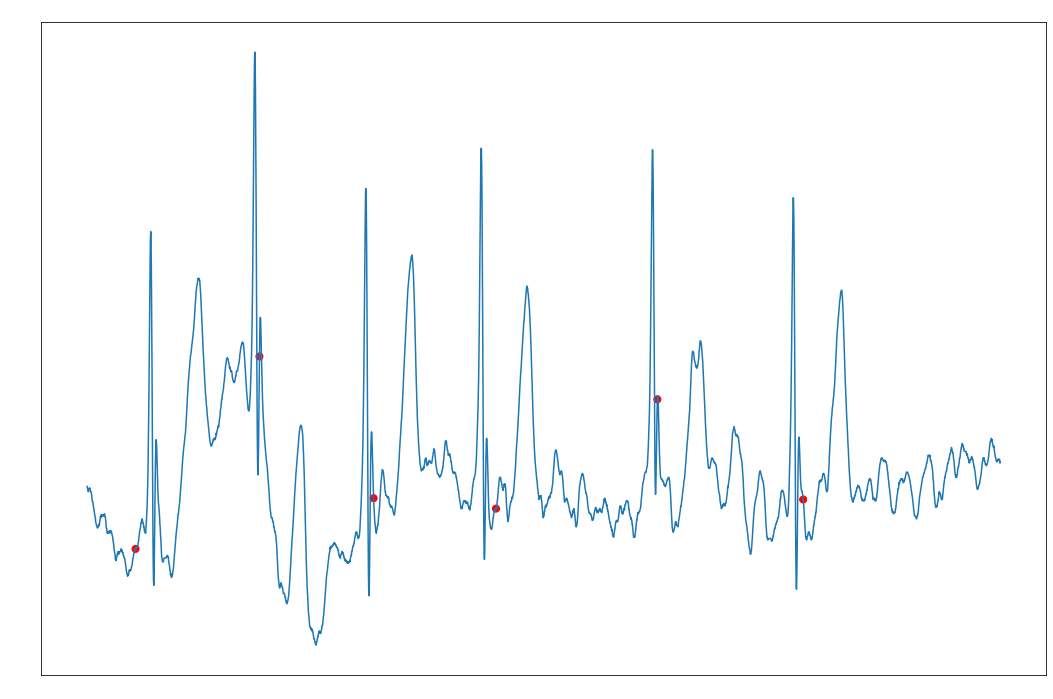

In [ ]:
#@title Pan-Tompkins on AF-data
AF_data = load_challenge_data("./Training_WFDB/A0009.mat")
AF_data = AF_data[0][1][0:3000]
AF_peaks=detectors.pan_tompkins_detector(AF_data)

plt.figure(figsize=(18,12))
plt.plot(AF_data)
plt.scatter(AF_peaks, AF_data[AF_peaks], s=[50,50,50,50,50,50], color = "red")
plt.title("AF Lead II", color = "white")
plt.tick_params(axis="both", colors = "white")

The Pan Tompkins code acually does not perform so bad on these data, but the way from here to finding the other features in the signal would be a a tedious job.

We therefore decided to try Deep Learning to solve the problem

In [ ]:
#@title Encode diagnosis
from sklearn.preprocessing import LabelEncoder
encode_df = LabelEncoder()
encode_df.fit(y)
encoded_y = encode_df.transform(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(encoded_y))))

Total number of unique combinations of diagnosis: 36


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Model
We are now ready to build the model. We will make a 1D CNN + LSTM model. But to be able to explain the whole model later on, we cant build it too complex (otherwise we use to much RAM)

In [ ]:
#@title Import necessary packages to make 1D CNN + LSTM model
from keras.optimizers import SGD, Adamax
from keras import utils
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, LSTM, Conv1D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import losses
from keras.callbacks import Callback
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend

In [ ]:
def create_model(learn_rate = 0.01, momentum = 0.8, filters = 20, strides = 5, kernel_size = 5, lstm_units = 5): 
  model = Sequential()
  model.add(Conv1D(filters=filters, strides= strides, kernel_size=kernel_size, activation='relu',input_shape=(1000,12)))
  model.add(LSTM(units = lstm_units))
  model.add(Dense(36, activation='softmax'))
  optimizer = SGD(lr=learn_rate, momentum = momentum)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy','categorical_accuracy',"categorical_crossentropy"])
  model.summary()
  return model

# Optimize hyperparameters on our selected model:

In [ ]:
#@title Reduce the data size for optimization
#We use stratified k-fold just as a method to get reduce our data for optimization, but at det same time
#keep the same distribution between classes
data_for_crossval= list(StratifiedKFold(n_splits=8, shuffle=True, random_state=42).split(X, o))
X_opt = X[data_for_crossval[0][1]]
y_opt_skf = encoded_y[data_for_crossval[0][1]]
from keras.utils import to_categorical
y_opt= to_categorical(y_opt_skf)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
#@title We wrap our Keras model in a sci-kit learn wrapper to do the optimization
model = KerasClassifier(build_fn=create_model, verbose=1, epochs = 10, batch_size = 10)
print("Done")

Done


In [ ]:
#@title We do a 3 fold validation on our data that we pass to the optimizer
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)

In [ ]:
#@title
from sklearn.model_selection import GridSearchCV
filters = [5, 10, 20]
param_grid = dict(filters=filters)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf.split(X_opt, y_opt_skf))
grid_result = grid.fit(X_opt, y_opt)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 5)            305       
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_1 (Dense)              (None, 36)                216       
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
573/573 [==============================] - 32s 56ms/step - loss: 3.5223 - accuracy: 0.1117 - categorical_accuracy: 0.1117 - categorical_crossentropy: 3.5223
Epoch 2/10
573/573 [==============================] - 26s 45ms/step - loss: 3.2071 - accuracy: 0.2007 - categorical_accuracy: 0.2007 - categorical_crossentropy: 3.2071
Epoch 3/10
573/573 [==============================

KeyboardInterrupt: ignored

In [ ]:
#@title Optimized 1D CNN filter size 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# ref: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

NameError: ignored

In [ ]:
#@title Optimize LSTM Units
lstm_units = [5, 10, 20]
param_grid = dict(lstm_units=lstm_units)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf.split(X_opt, y_opt_skf))
grid_result = grid.fit(X_opt, y_opt)

In [ ]:
#@title Optimized LSTM units 
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# ref: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
# @title optimize learning rate

learn_rate = [0.005, 0.01, 0.05, 0.1]
momentum = [0.2, 0.5, 0.08]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf.split(X_opt, y_opt_skf))
grid_result = grid.fit(X_opt, y_opt)

In [ ]:
#@title Optimized Learning rate and Momentum
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# [4]

In [ ]:
#@title Optimize batch size
batch_size = [10, 20, 40]
param_grid = dict(batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf.split(X_opt, y_opt_skf))
grid_result = grid.fit(X_opt, y_opt)

In [ ]:
#@title Optimized Batch size
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# ref: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Bulid the final model on all data and optimized values

In [ ]:
#@title Create model
model = create_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 200, 20)           1220      
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 520       
_________________________________________________________________
dense_2 (Dense)              (None, 36)                216       
Total params: 1,956
Trainable params: 1,956
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#@title One hot encode y-label
from keras.utils import to_categorical
y_new= to_categorical(encoded_y)

In [ ]:
#@title
data_for_train_and_test= list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(X, o))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
#@title
X_test = X[data_for_train_and_test[0][1]]
y_test = y_new[data_for_train_and_test[0][1]]
X_train = X[data_for_train_and_test[0][0]]
y_train = y_new[data_for_train_and_test[0][0]]

In [ ]:
#@title
history = model.fit(X_train,y_train,batch_size = 10, epochs = 10 )

Epoch 1/10
6189/6189 [==============================] - 283s 46ms/step - loss: 2.5677 - accuracy: 0.2168 - categorical_accuracy: 0.2168 - categorical_crossentropy: 2.5677
Epoch 2/10
6189/6189 [==============================] - 280s 45ms/step - loss: 2.3492 - accuracy: 0.2223 - categorical_accuracy: 0.2223 - categorical_crossentropy: 2.3492
Epoch 3/10
6189/6189 [==============================] - 282s 46ms/step - loss: 2.3325 - accuracy: 0.2228 - categorical_accuracy: 0.2228 - categorical_crossentropy: 2.3325
Epoch 4/10
6189/6189 [==============================] - 281s 45ms/step - loss: 2.3255 - accuracy: 0.2228 - categorical_accuracy: 0.2228 - categorical_crossentropy: 2.3255
Epoch 5/10
6189/6189 [==============================] - 282s 46ms/step - loss: 2.3224 - accuracy: 0.2228 - categorical_accuracy: 0.2228 - categorical_crossentropy: 2.3224
Epoch 6/10
6189/6189 [==============================] - 283s 46ms/step - loss: 2.3193 - accuracy: 0.2228 - categorical_accuracy: 0.2228 - categor

# Plot information about training:

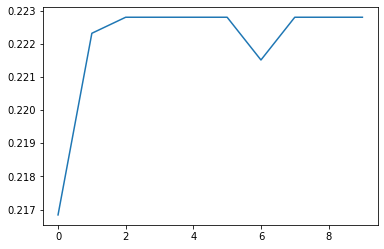

In [ ]:
#@title Plot accuracy during training
plt.plot(history.history['accuracy'])
plt.show()

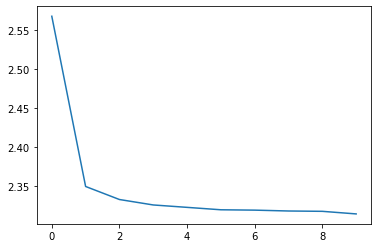

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 2.0MB 8.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=3f3e97de6bdb1b0251dc70f0f0e2f789fde4f947a4a57f60283bd4222994e32d
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Successfully built lime
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


# Scoring

First we start by doing prediction on all our training data

In [ ]:
#@title Define function to get probability score from model
def run_12ECG_classifier(data,model):
    reshaped12lead = data.reshape(1,1000,12)
    score = model.predict(reshaped12lead)
    score = score.ravel()
    return score
print("Done")

Done


In [ ]:
#@title Get probability score from all our test data
probability_score = []
for i in range(X_test.shape[0]):
  p = run_12ECG_classifier(X_test[i], model)
  probability_score.append(p)
probability_score=np.array(probability_score)
print("Shape probability score array: {}".format(probability_score.shape))

Shape probability score array: (688, 36)


In [ ]:
probability_score[0]

array([0.14700693, 0.00416529, 0.00079092, 0.00098999, 0.00146888,
       0.02106152, 0.00426553, 0.00083264, 0.10520713, 0.0013133 ,
       0.00089587, 0.00107616, 0.00157079, 0.00108988, 0.00109032,
       0.03020147, 0.00164129, 0.00099891, 0.00099402, 0.13469149,
       0.07769482, 0.00086835, 0.00111063, 0.00080135, 0.09049913,
       0.00252976, 0.00086532, 0.2119621 , 0.0070104 , 0.00090461,
       0.00797193, 0.00276736, 0.00233861, 0.1030053 , 0.00089107,
       0.0274269 ], dtype=float32)

In [ ]:
#@title Optimization of prediction thresholds based on F2 and G2 scores. We start with an initial guess of 0.1 for all classes
from scipy import optimize
init_threshold = np.ones(36)*0.1
print("Initial threshold: {}".format(init_threshold))
# [7]

Initial threshold: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [ ]:
#@title Define F2 score
def compute_score_f2(labels, output):
    
    beta = 2
    num_classes = 36
    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return f_beta
print("Done")

Done


In [ ]:
#@title Define G2-score function
def compute_score_g2(labels, output):
    
    beta = 2
    num_classes = 36
    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return g_beta
print("Done")
#[5]

Done


In [ ]:
#@title Optimize prediction threshold based on F2-score (this will take 3-4min)
def thr_to_accuracy_f2(thr, labels, output_prob):
    return -compute_score_f2(labels, np.array(output_prob>thr, dtype=np.int))
best_thr_f2 = optimize.fmin(thr_to_accuracy_f2, args=(y_test, probability_score), x0=init_threshold)

Optimization terminated successfully.
         Current function value: -0.340137
         Iterations: 44
         Function evaluations: 304


In [ ]:
#@title Thresholds for optimized F2-score
for i in range(len(best_thr_f2)):
  print("Best threshold for {} is: {}".format(encode_df.classes_[i], best_thr_f2[i]))


Best threshold for AF is: 0.10027777777777788
Best threshold for AF,LBBB is: 0.10027777777777788
Best threshold for AF,LBBB,STD is: 0.10027777777777788
Best threshold for AF,PAC is: 0.10027777777777788
Best threshold for AF,PVC is: 0.10027777777777788
Best threshold for AF,RBBB is: 0.10027777777777788
Best threshold for AF,STD is: 0.10027777777777788
Best threshold for AF,STE is: 0.10027777777777788
Best threshold for I-AVB is: 0.10027777777777788
Best threshold for I-AVB,LBBB is: 0.10027777777777788
Best threshold for I-AVB,PAC is: 0.10027777777777788
Best threshold for I-AVB,PVC is: 0.10027777777777788
Best threshold for I-AVB,RBBB is: 0.10027777777777788
Best threshold for I-AVB,STD is: 0.10027777777777788
Best threshold for I-AVB,STE is: 0.10027777777777788
Best threshold for LBBB is: 0.10027777777777788
Best threshold for LBBB,PAC is: 0.10027777777777788
Best threshold for LBBB,PVC is: 0.10027777777777788
Best threshold for LBBB,STE is: 0.10027777777777788
Best threshold for Norma

In [ ]:
#@title Optimize prediction thresholds based on G2-score this will take 2-3min)
def thr_to_accuracy_g2(thr, labels, output_prob):
    return -compute_score_g2(labels, np.array(output_prob>thr, dtype=np.int))
best_thr_g2 = optimize.fmin(thr_to_accuracy_g2, args=(y_test, probability_score), x0=best_thr_f2)

Optimization terminated successfully.
         Current function value: -0.298063
         Iterations: 9
         Function evaluations: 268


In [ ]:
#@title Thresholds for optimized G2-score
for i in range(len(best_thr_g2)):
  print("Best threshold for {} is: {}".format(encode_df.classes_[i], best_thr_g2[i]))


Best threshold for AF is: 0.10027777777777788
Best threshold for AF,LBBB is: 0.10027777777777788
Best threshold for AF,LBBB,STD is: 0.10027777777777788
Best threshold for AF,PAC is: 0.10027777777777788
Best threshold for AF,PVC is: 0.10027777777777788
Best threshold for AF,RBBB is: 0.10027777777777788
Best threshold for AF,STD is: 0.10027777777777788
Best threshold for AF,STE is: 0.10027777777777788
Best threshold for I-AVB is: 0.10027777777777788
Best threshold for I-AVB,LBBB is: 0.10027777777777788
Best threshold for I-AVB,PAC is: 0.10027777777777788
Best threshold for I-AVB,PVC is: 0.10027777777777788
Best threshold for I-AVB,RBBB is: 0.10027777777777788
Best threshold for I-AVB,STD is: 0.10027777777777788
Best threshold for I-AVB,STE is: 0.10027777777777788
Best threshold for LBBB is: 0.10027777777777788
Best threshold for LBBB,PAC is: 0.10027777777777788
Best threshold for LBBB,PVC is: 0.10027777777777788
Best threshold for LBBB,STE is: 0.10027777777777788
Best threshold for Norma

In [ ]:
#@title The mean of F2 and G2 thresholdS
new_thr=(best_thr_f2+best_thr_g2)/2
for i in range(len(new_thr)):
  print("Best threshold for {} is: {}".format(encode_df.classes_[i], new_thr[i]))


Best threshold for AF is: 0.10027777777777788
Best threshold for AF,LBBB is: 0.10027777777777788
Best threshold for AF,LBBB,STD is: 0.10027777777777788
Best threshold for AF,PAC is: 0.10027777777777788
Best threshold for AF,PVC is: 0.10027777777777788
Best threshold for AF,RBBB is: 0.10027777777777788
Best threshold for AF,STD is: 0.10027777777777788
Best threshold for AF,STE is: 0.10027777777777788
Best threshold for I-AVB is: 0.10027777777777788
Best threshold for I-AVB,LBBB is: 0.10027777777777788
Best threshold for I-AVB,PAC is: 0.10027777777777788
Best threshold for I-AVB,PVC is: 0.10027777777777788
Best threshold for I-AVB,RBBB is: 0.10027777777777788
Best threshold for I-AVB,STD is: 0.10027777777777788
Best threshold for I-AVB,STE is: 0.10027777777777788
Best threshold for LBBB is: 0.10027777777777788
Best threshold for LBBB,PAC is: 0.10027777777777788
Best threshold for LBBB,PVC is: 0.10027777777777788
Best threshold for LBBB,STE is: 0.10027777777777788
Best threshold for Norma

In [ ]:
#@title Make a Classifier which use the new thresholds
def run_12ECG_classifier_opt_thr(data,model,threshold):

    reshaped12lead = data.reshape(1,1000,12)
    score = model.predict_proba(reshaped12lead)
    score = score.ravel()
    binary_prediction = score > threshold
    binary_prediction = binary_prediction * 1

    return binary_prediction
print("Done")

Done


In [ ]:
#@title Do classification
optimized_binary = []
for i in range(X_test.shape[0]):
  b = run_12ECG_classifier_opt_thr(X_test[i], model, new_thr)
  optimized_binary.append(b)
optimized_binary = np.array(optimized_binary)
print("Shape of Classified outputs: {}".format(optimized_binary.shape))

Shape of Classified outputs: (688, 36)


In [ ]:
#@title Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,optimized_binary))


              precision    recall  f1-score   support

           0       0.14      1.00      0.25        97
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.13      0.72      0.22        68
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00        18
          16       0.00      0.00      0.00         1
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## We can visualize by making 36 confusion matrixes

In [ ]:
#@title install library for multilabel_confusion_matrix
!pip install git+http://github.com/scikit-learn/scikit-learn.git
print("Done")

  Cloning http://github.com/scikit-learn/scikit-learn.git to /tmp/pip-req-build-hsuch7mb
  Running command git clone -q http://github.com/scikit-learn/scikit-learn.git /tmp/pip-req-build-hsuch7mb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn: filename=scikit_learn-0.24.dev0-cp36-cp36m-linux_x86_64.whl size=17864925 sha256=3fbfd3e8482d44c4d89f09100490d2a66e476b826d3d149fa7c1346e3ff44635
  Stored in directory: /tmp/pip-ephem-wheel-cache-zhjcctvg/wheels/ec/59/9a/0fba63f83339d1b28888fbe388362cacb251b22521267a64e5
Successfully built scikit-learn
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Done


This package has to be downloaded via git (https://stackoverflow.com/questions/55877681/importerror-cannot-import-name-multilabel-confusion-matrix )

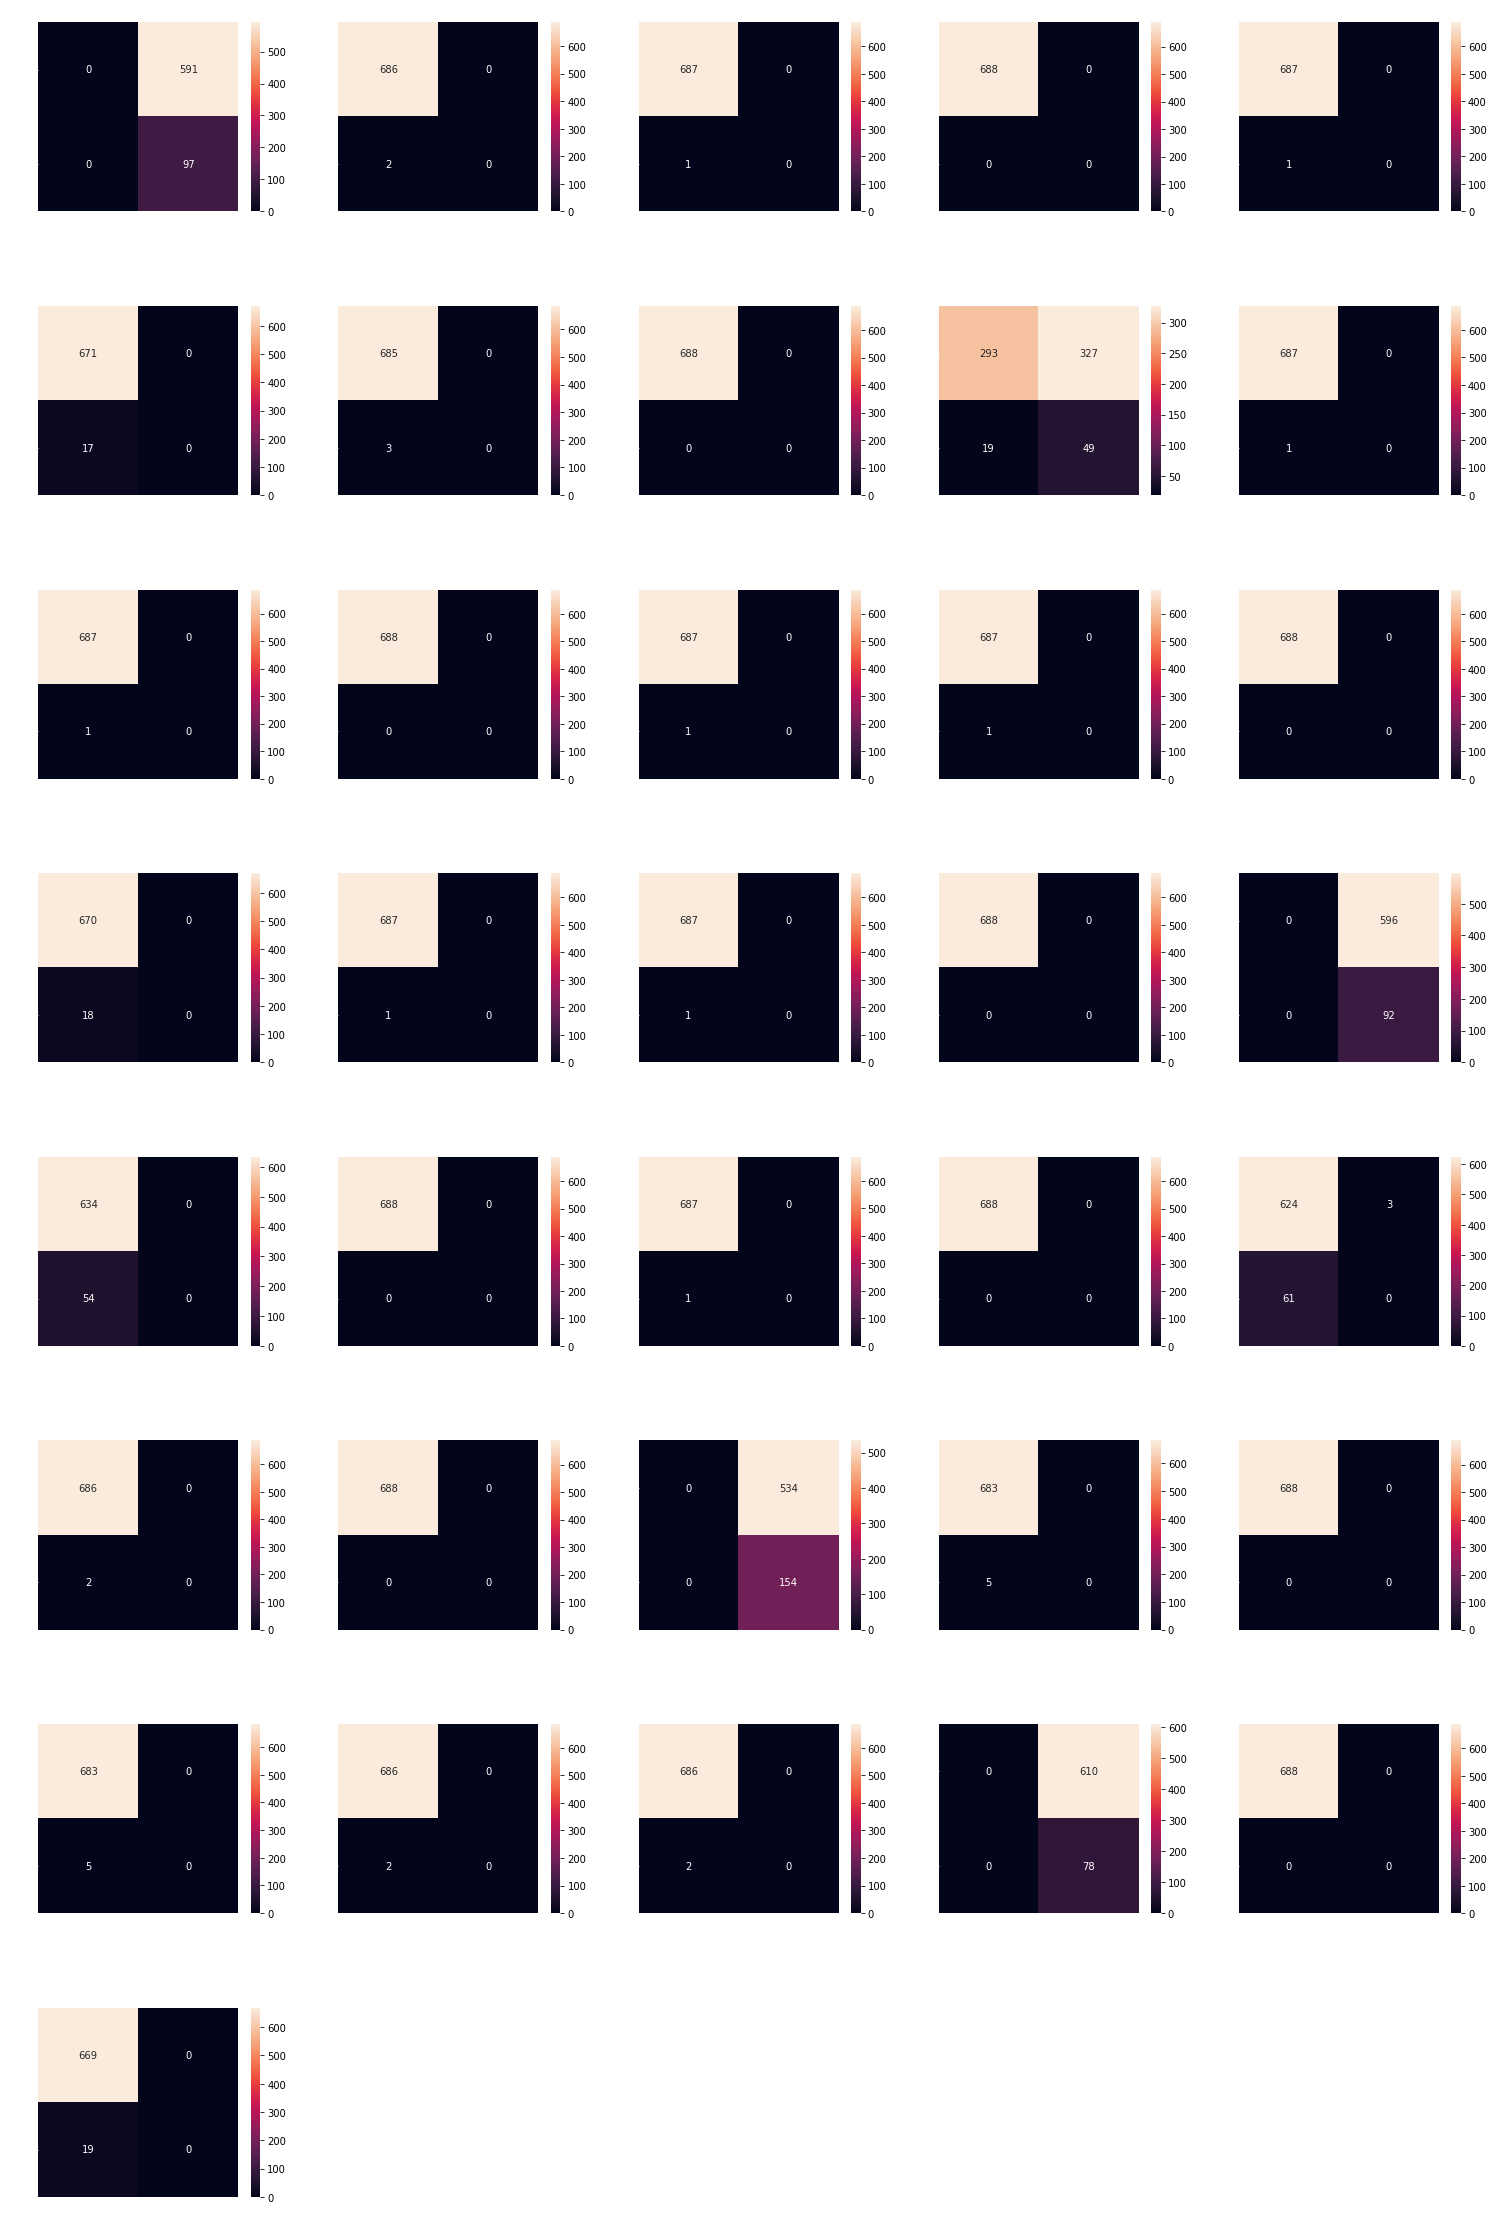

In [ ]:
#@title Plot Confusion matrix for all classes
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(y_test,optimized_binary)
plt.figure(figsize=(26, 40))
for i in range(mcm.shape[0]):
    plt.subplot(8, 5, i + 1)
    plt.subplots_adjust(hspace=0.5)
    sns.heatmap(mcm[i], annot=True, fmt='g', yticklabels=["False","True"], xticklabels=["False","True"])
    plt.title(encode_df.classes_[i], color = "white")
    plt.tick_params(axis="both", colors = "white")
    plt.xlabel("Y True", color = "white")
    plt.ylabel("Y Predicted", color = "white")

Lets see what the F2 and G2 score will be

In [ ]:
#@title Compute F2 score for classification
print("F2-score:")
compute_score_f2(y_test,optimized_binary)

F2-score:


0.3401368547869153

In [ ]:
#@title Compute G2 score for classification
print("G2-score:")
compute_score_g2(y_test,optimized_binary)

G2-score:


0.2980632247937186

In [ ]:
#@title
np.where(y_test[1])

(array([27]),)

# And finally! Lets see if we can make this model explainable with Lime

In [ ]:
import lime
from lime import lime_tabular
explainer2 = lime_tabular.RecurrentTabularExplainer(X[:10], training_labels=encoded_y[:10], feature_names=["Lead-I","Lead-II", "Lead-III","aVR","aVL","aVF","V1","V2","V3","V4","V5","V6"],
                                                   discretize_continuous=True,
                                                    class_names=encode_df.classes_,
                                                   discretizer='decile')

In [ ]:
exp = explainer2.explain_instance(X[1], model.predict, num_features=8, labels=(27,))
exp.show_in_notebook()
# [6]

AttributeError: ignored

In [ ]:
load_challenge_data("./Training_WFDB/A0001.mat")[1][15]

# Conclusion
This person actually has RBBB and we can see that the Leads that is used to give that answer is V6, Lead II, aVF and V3. From our PowerPoint-presentation in the project you can see that doctors typically use V1 and V6 to diagnose RBBB. This strengthen the algorithm since doctors and the model use the same at least one of the same Lead to classify this disease.


# Reference

[1] http://2018.icbeb.org/Challenge.html

[2] Liu, Feifei, Chengyu Liu, Lina Zhao, Xiangyu Zhang, Xiaoling Wu, Xiaoyan Xu, Yulin Liu, et al. “An Open Access Database for Evaluating the Algorithms of Electrocardiogram Rhythm and Morphology Abnormality Detection.” Journal of Medical Imaging and Health Informatics 8, no. 7 (September 1, 2018): 1368–73. https://doi.org/10.1166/jmihi.2018.2442.

[3] Pan, Jiapu, and Willis J. Tompkins. “A Real-Time QRS Detection Algorithm.” IEEE Transactions on Biomedical Engineering BME-32, no. 3 (March 1985): 230–36. https://doi.org/10.1109/TBME.1985.325532.

[4]  https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ 

[5] https://github.com/physionetchallenges/evaluation-2020

[6] https://github.com/marcotcr/lime/blob/master/doc/notebooks/Lime%20with%20Recurrent%20Neural%20Networks.ipynb

[7] https://stackoverflow.com/questions/52093388/how-to-choose-optimal-threshold-for-class-probabilities ]


# Appendix
## Further exploration for improving model
### Explore age and gender

In [ ]:
#@title
o=[]
for filen in sorted(os.listdir("./Training_WFDB/")):
    if filen.endswith(".mat"):
        data, header_data = load_challenge_data("./Training_WFDB/"+filen)
        o.append(header_data)

In [ ]:
new_list =[]
for i in range(len(o)):
  list_obj1 = o[i][13:]
  list_obj2 = o[i][0][0:5]
  list_obj1.append(list_obj2)
  new_list.append(list_obj1)
new_list[0]

['#Age: 74\n',
 '#Sex: Male\n',
 '#Dx: RBBB\n',
 '#Rx: Unknown\n',
 '#Hx: Unknown\n',
 '#Sx: Unknown\n',
 'A0001']

In [ ]:
new_df = pd.DataFrame(new_list, columns = ["Age", "Sex", "Diagnosis","Rx", "Hx", "Sx", "Patient nr"])
new_df = new_df.set_index('Patient nr')

In [ ]:
new_df['Age']=new_df['Age'].str.lstrip("#Age:").str.rstrip("\n")
new_df['Sex']=new_df['Sex'].str.lstrip("#Sex:").str.rstrip("\n")
new_df['Diagnosis']=new_df['Diagnosis'].str.lstrip("#Dx:").str.rstrip("\n")
new_df = new_df.iloc[:,0:3]
new_df.head()

,Age,Sex,Diagnosis
Patient nr,,,
A0001,74,Male,RBBB
A0002,49,Female,Normal
A0003,81,Female,AF
A0004,45,Male,AF
A0005,53,Male,PVC


In [ ]:
new_df.dtypes

Age          object
Sex          object
Diagnosis    object
dtype: object

In [ ]:
new_df['Age']=pd.to_numeric(new_df['Age'], errors='coerce', downcast='integer')

In [ ]:
new_df.dtypes

Age          float64
Sex           object
Diagnosis     object
dtype: object

In [ ]:
np.where(new_df['Age'].isna())

(array([ 607, 1548, 1875, 2298, 5989]),)

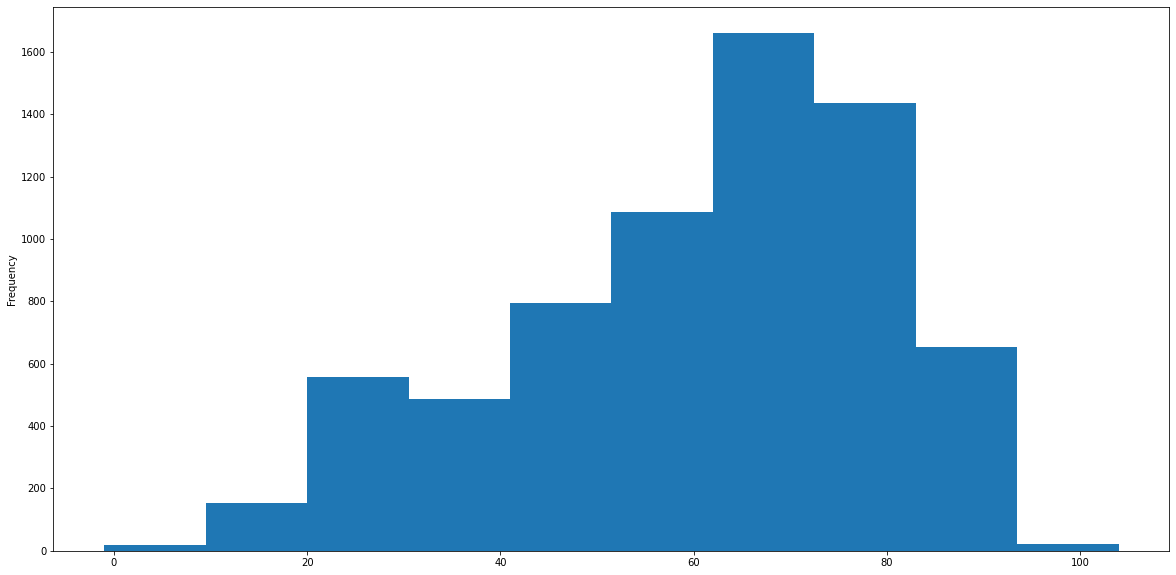

In [ ]:
new_df.Age.plot.hist(figsize=(20,10))

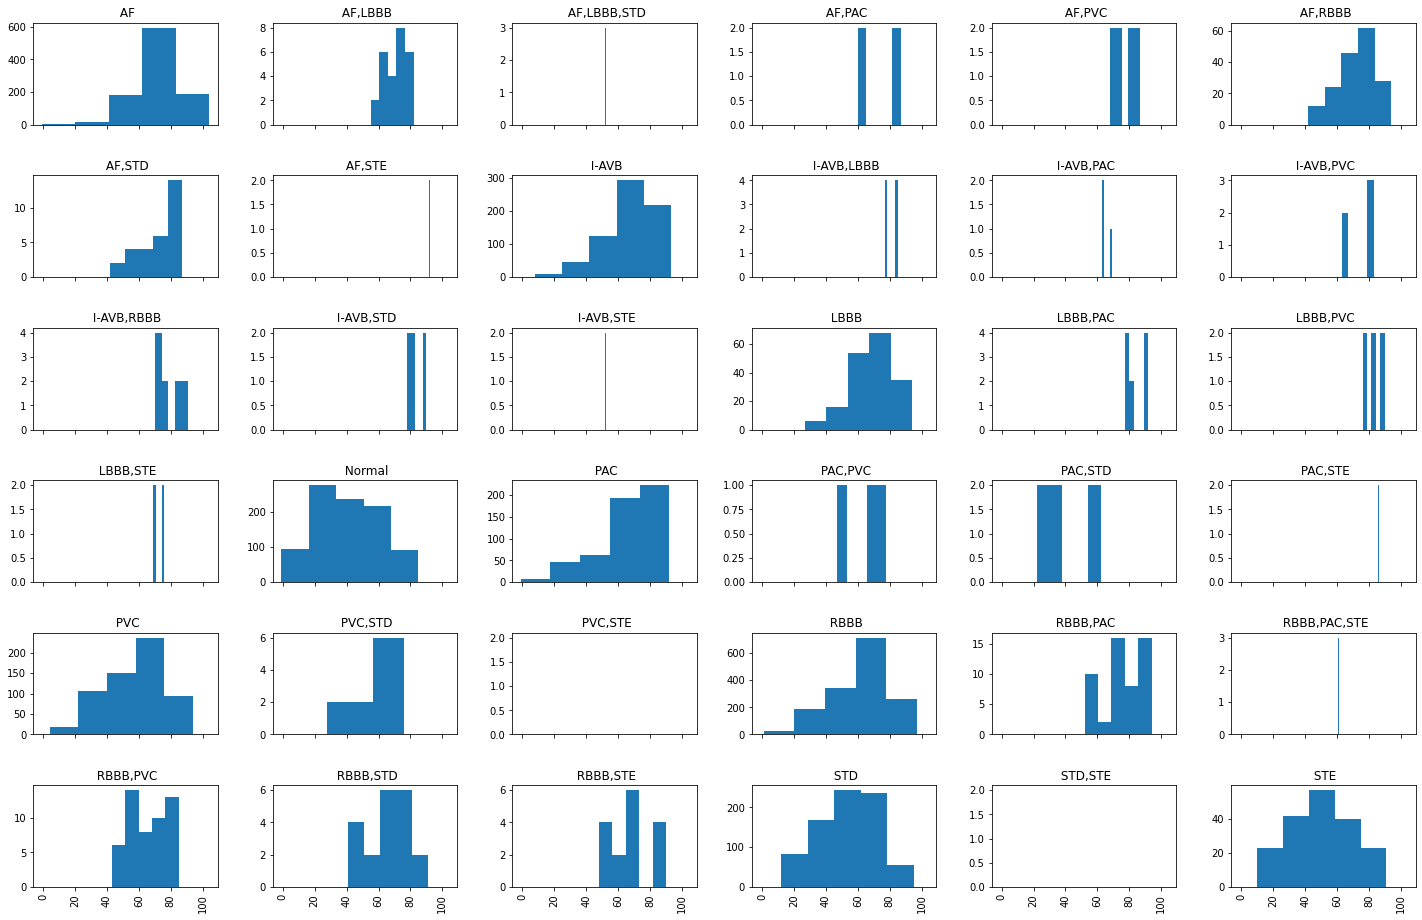

In [ ]:
new_df['Age'].hist(by=new_df['Diagnosis'], figsize=(24,16), sharex = True, bins = 5)
plt.show()


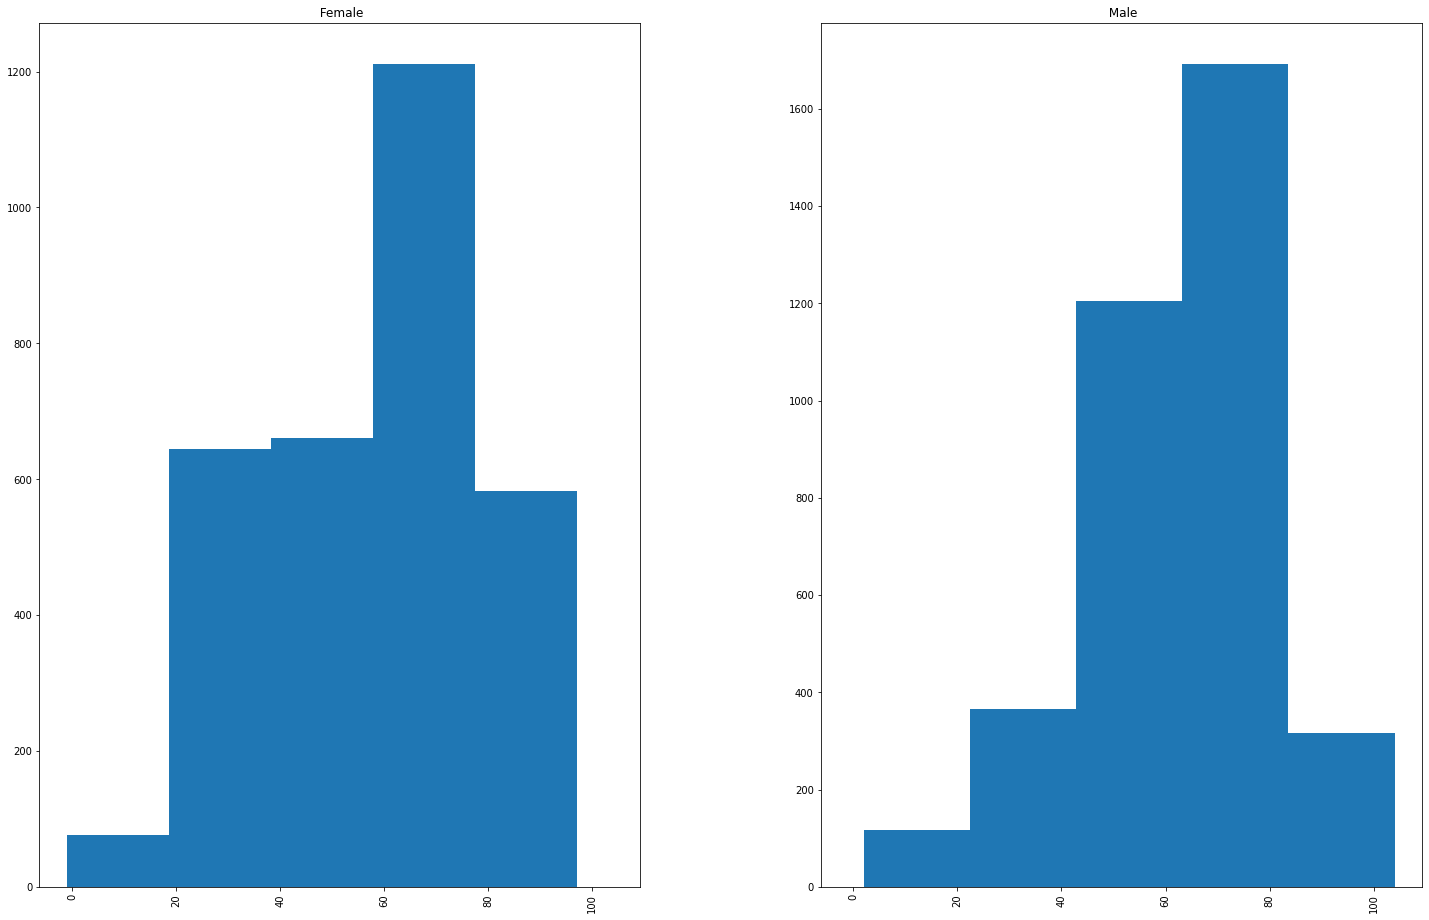

In [ ]:
new_df['Age'].hist(by=new_df['Sex'], figsize=(24,16), sharex = True, bins = 5)
plt.show()

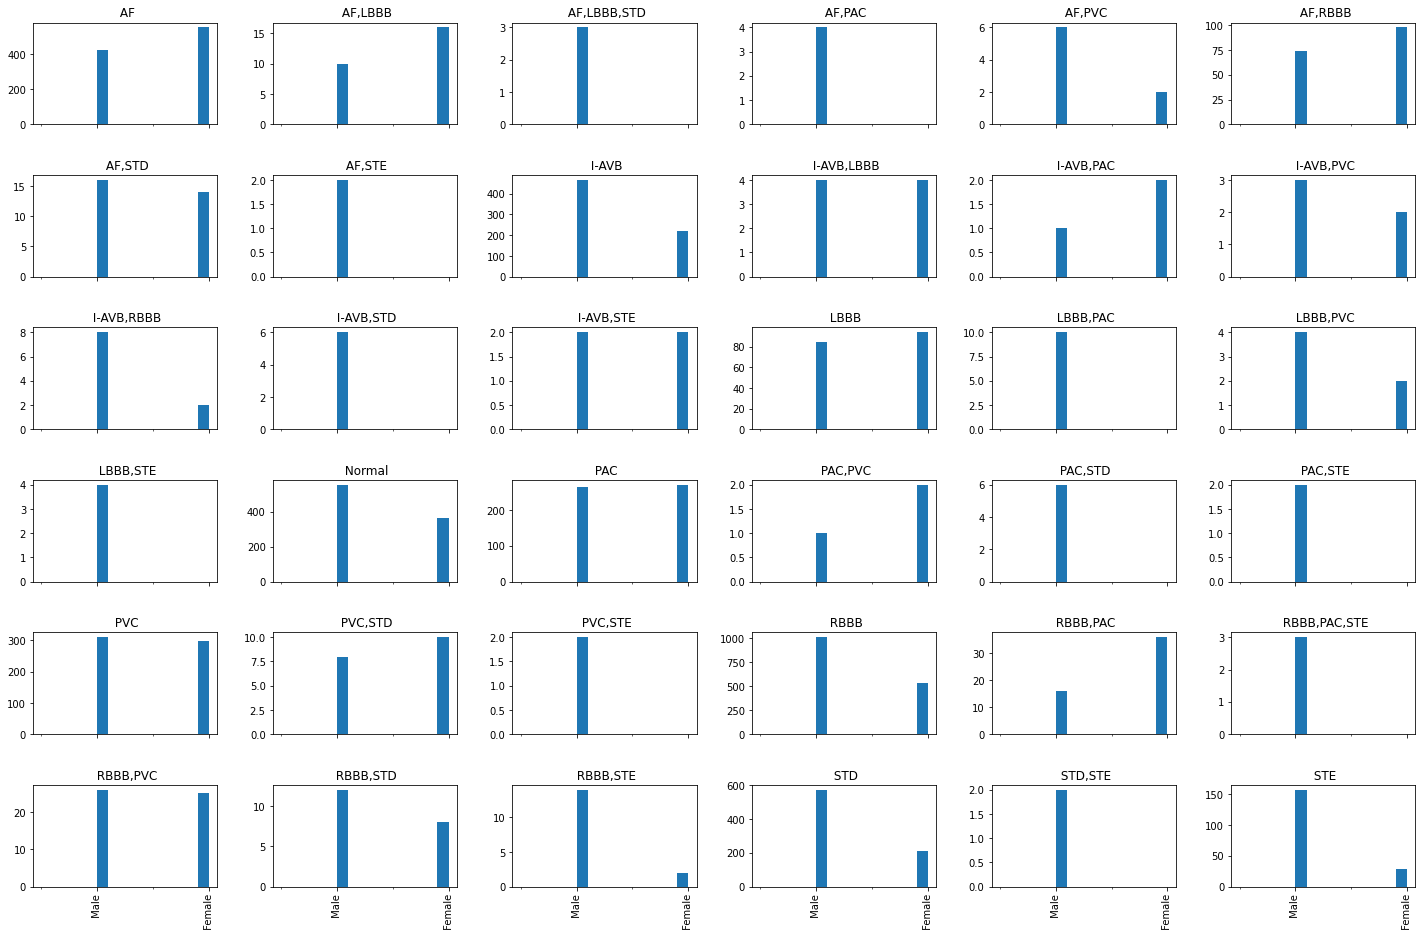

In [ ]:
new_df['Sex'].hist(by=new_df['Diagnosis'], figsize=(24,16), sharex = True)
plt.show()